# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [32]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from abc import ABC
from abc import ABCMeta
import abc




In [5]:
project_folder='Project_data'


In [6]:
#plotting grpahs

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [ ]:
train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
batch_size = #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/notebooks/storage/Final_data/Collated_training/train'
val_path = '/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = # choose the number of epochs
print ('# epochs =', num_epochs)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

In [10]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 147s 6s/step - loss: 1.4844 - categorical_accuracy: 0.4733 - val_loss: 2.1074 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model_init_2020-09-0314_50_24.562434/model-00001-1.46225-0.49170-2.10742-0.41000.h5
Epoch 2/3
23/23 [==============================] - 52s 2s/step - loss: 1.0011 - categorical_accuracy: 0.6313 - val_loss: 0.9785 - val_categorical_accuracy: 0.6700

Epoch 00002: saving model to model_init_2020-09-0314_50_24.562434/model-00002-1.01382-0.61689-0.97850-0.67000.h5
Epoch 3/3
23/23 [==============================] - 54s 2s/step - loss: 0.7505 - categorical_accuracy: 0.7300 - val_loss: 0.9670 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2020-09-0314_50_24.562434/model-00003-0.77691-0.71946-0.96700-0.65000.h5


In [11]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 162s 7s/step - loss: 1.6197 - categorical_accuracy: 0.3711 - val_loss: 1.7125 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2020-09-0314_57_28.045096/model-00001-1.61947-0.37255-1.71252-0.33000.h5
Epoch 2/2
23/23 [==============================] - 73s 3s/step - loss: 1.2141 - categorical_accuracy: 0.5525 - val_loss: 1.0940 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2020-09-0314_57_28.045096/model-00002-1.11964-0.56109-1.09397-0.54000.h5


In [9]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


45/45 [==============================] - 227s 5s/step - loss: 1.6040 - categorical_accuracy: 0.4104 - val_loss: 2.6071 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2020-09-0414_16_30.956598/model-00001-1.61027-0.41176-2.60706-0.30000.h5
Epoch 2/2
45/45 [==============================] - 87s 2s/step - loss: 1.1416 - categorical_accuracy: 0.5660 - val_loss: 1.4565 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2020-09-0414_16_30.956598/model-00002-1.11158-0.57014-1.45654-0.54000.h5


In [10]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 57s 3s/step - loss: 1.5723 - categorical_accuracy: 0.4429 - val_loss: 1.8633 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2020-09-0414_22_55.451015/model-00001-1.57625-0.43891-1.86329-0.54000.h5
Epoch 2/2
17/17 [==============================] - 44s 3s/step - loss: 0.9352 - categorical_accuracy: 0.6456 - val_loss: 0.9936 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-09-0414_22_55.451015/model-00002-0.93339-0.64857-0.99357-0.65000.h5


As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

## Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [11]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

NameError: name 'history_model2' is not defined

In [12]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 10, 80, 80, 32)    128       
__________

In [13]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 73s 4s/step - loss: 1.6002 - categorical_accuracy: 0.3961 - val_loss: 2.9268 - val_categorical_accuracy: 0.3100

Epoch 00001: saving model to model_init_2020-09-0414_30_30.304478/model-00001-1.60258-0.39517-2.92684-0.31000.h5
Epoch 2/15
17/17 [==============================] - 54s 3s/step - loss: 1.1913 - categorical_accuracy: 0.5130 - val_loss: 1.7556 - val_categorical_accuracy: 0.4200

Epoch 00002: saving model to model_init_2020-09-0414_30_30.304478/model-00002-1.19057-0.51282-1.75561-0.42000.h5
Epoch 3/15
17/17 [==============================] - 59s 3s/step - loss: 0.9555 - categorical_accuracy: 0.6225 - val_loss: 1.1006 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2020-09-0414_30_30.304478/model-00003-0.95528-0.62594-1.10058-0.56000.h5
Epoch 4/15
17/17 [==============================] - 59s 3s/step - loss: 0.7278 - categorical_accuracy: 0.7345 - val_loss: 0.8330 - val_categorical_accuracy: 0.6900

Epoch 00004:

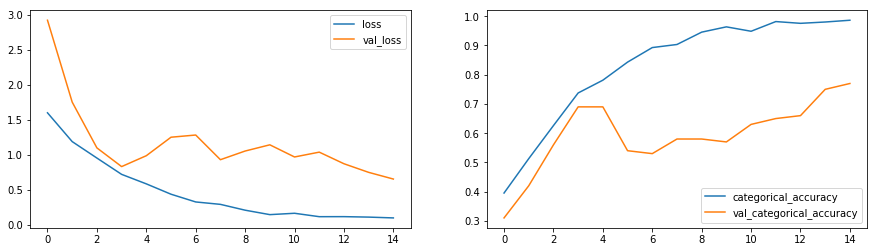

In [14]:
plot(history_model1)

#### Model is clearly overfitting. So we need to do data augmentation

## Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [12]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 80, 80, 32)    128       
__________

In [13]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 276s 8s/step - loss: 1.8312 - categorical_accuracy: 0.4014 - val_loss: 2.2610 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2020-09-0714_10_55.552021/model-00001-1.82561-0.39894-2.26096-0.40000.h5
Epoch 2/25
34/34 [==============================] - 132s 4s/step - loss: 1.3722 - categorical_accuracy: 0.5335 - val_loss: 1.6736 - val_categorical_accuracy: 0.5100

Epoch 00002: saving model to model_init_2020-09-0714_10_55.552021/model-00002-1.37347-0.53017-1.67357-0.51000.h5
Epoch 3/25
34/34 [==============================] - 133s 4s/step - loss: 1.2329 - categorical_accuracy: 0.5850 - val_loss: 1.2358 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-09-0714_10_55.552021/model-00003-1.21350-0.58296-1.23584-0.61000.h5
Epoch 4/25
34/34 [==============================] - 134s 4s/step - loss: 0.9915 - categorical_accuracy: 0.6431 - val_loss: 2.1314 - val_categorical_accuracy: 0.4400

Epoch 00

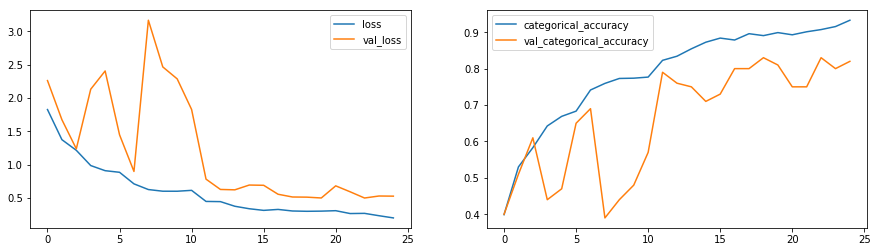

In [14]:
plot(history_model2)


#### Model is not overfitting and we get a best validation accuracy of 83% . Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002

## Model 3 - Reduce filter size to (2,2,2) and image res to 120 x 120

In [15]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 60, 60, 32)     128       
__________

In [17]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 142s 6s/step - loss: 2.2803 - categorical_accuracy: 0.3028 - val_loss: 1.1235 - val_categorical_accuracy: 0.5600

Epoch 00001: saving model to model_init_2020-09-0715_10_39.119864/model-00001-2.30909-0.30166-1.12347-0.56000.h5
Epoch 2/30
23/23 [==============================] - 86s 4s/step - loss: 1.5100 - categorical_accuracy: 0.4956 - val_loss: 0.9101 - val_categorical_accuracy: 0.6700

Epoch 00002: saving model to model_init_2020-09-0715_10_39.119864/model-00002-1.52035-0.49548-0.91013-0.67000.h5
Epoch 3/30
23/23 [==============================] - 88s 4s/step - loss: 1.2927 - categorical_accuracy: 0.5281 - val_loss: 1.0353 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-09-0715_10_39.119864/model-00003-1.27599-0.54223-1.03532-0.64000.h5
Epoch 4/30
23/23 [==============================] - 88s 4s/step - loss: 1.2892 - categorical_accuracy: 0.5671 - val_loss: 0.9645 - val_categorical_accuracy: 0.7000

Epoch 00004

23/23 [==============================] - 87s 4s/step - loss: 0.6319 - categorical_accuracy: 0.7695 - val_loss: 0.7908 - val_categorical_accuracy: 0.7500

Epoch 00030: saving model to model_init_2020-09-0715_10_39.119864/model-00030-0.63407-0.76697-0.79085-0.75000.h5


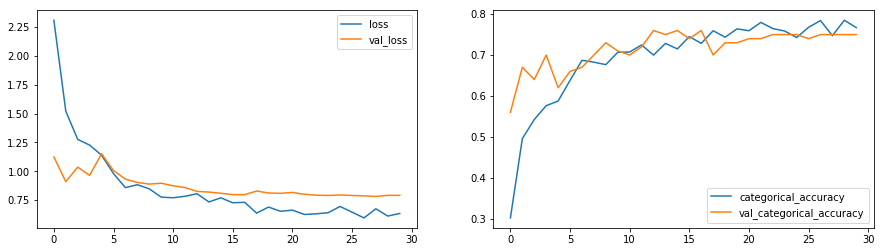

In [18]:
plot(history_model3)


#### Model has a best validation accuracy of 76% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 4 - Adding more layers

In [19]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_10 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [21]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 112s 3s/step - loss: 1.9952 - categorical_accuracy: 0.3602 - val_loss: 12.3227 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-09-0715_55_37.689989/model-00001-2.01120-0.35671-12.32273-0.23000.h5
Epoch 2/30
34/34 [==============================] - 93s 3s/step - loss: 1.5214 - categorical_accuracy: 0.4908 - val_loss: 3.6950 - val_categorical_accuracy: 0.3600

Epoch 00002: saving model to model_init_2020-09-0715_55_37.689989/model-00002-1.48784-0.49472-3.69501-0.36000.h5
Epoch 3/30
34/34 [==============================] - 94s 3s/step - loss: 1.2154 - categorical_accuracy: 0.5714 - val_loss: 4.3152 - val_categorical_accuracy: 0.3400

Epoch 00003: saving model to model_init_2020-09-0715_55_37.689989/model-00003-1.21665-0.57315-4.31518-0.34000.h5
Epoch 4/30
34/34 [==============================] - 96s 3s/step - loss: 1.1233 - categorical_accuracy: 0.5850 - val_loss: 1.3755 - val_categorical_accuracy: 0.5700

Epoch 000


Epoch 00029: saving model to model_init_2020-09-0715_55_37.689989/model-00029-0.20263-0.92911-0.49494-0.81000.h5
Epoch 30/30
34/34 [==============================] - 98s 3s/step - loss: 0.2056 - categorical_accuracy: 0.9389 - val_loss: 0.4900 - val_categorical_accuracy: 0.8100

Epoch 00030: saving model to model_init_2020-09-0715_55_37.689989/model-00030-0.19141-0.94570-0.48998-0.81000.h5


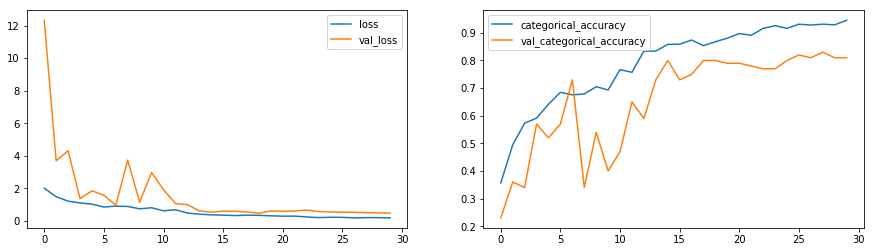

In [22]:
plot(history_model4)


#### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

## Model 5 Adding dropout at convolution layers

In [23]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_18 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [25]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 109s 3s/step - loss: 1.8516 - categorical_accuracy: 0.3319 - val_loss: 2.9298 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-09-0716_45_24.407158/model-00001-1.85637-0.33183-2.92980-0.36000.h5
Epoch 2/22
34/34 [==============================] - 93s 3s/step - loss: 1.4397 - categorical_accuracy: 0.4599 - val_loss: 1.9710 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-09-0716_45_24.407158/model-00002-1.41811-0.46305-1.97101-0.47000.h5
Epoch 3/22
34/34 [==============================] - 98s 3s/step - loss: 1.2822 - categorical_accuracy: 0.4871 - val_loss: 1.1134 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-09-0716_45_24.407158/model-00003-1.23440-0.49925-1.11345-0.61000.h5
Epoch 4/22
34/34 [==============================] - 99s 3s/step - loss: 1.0513 - categorical_accuracy: 0.5721 - val_loss: 0.8874 - val_categorical_accuracy: 0.6500

Epoch 00004

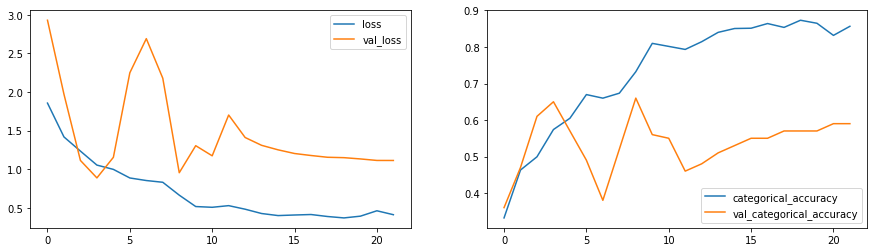

In [26]:
plot(history_model5)


#### Adding dropouts has further reduced validation accuracy as its not to learn generalizable features. All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 - reducing the number of parameters

In [8]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 50, 50, 32)     128       
__________

In [10]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 197s 6s/step - loss: 1.9002 - categorical_accuracy: 0.3366 - val_loss: 1.4628 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-09-0814_17_10.555120/model-00001-1.90162-0.33258-1.46283-0.47000.h5
Epoch 2/30
34/34 [==============================] - 83s 2s/step - loss: 1.2831 - categorical_accuracy: 0.4934 - val_loss: 0.9809 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-09-0814_17_10.555120/model-00002-1.27622-0.50151-0.98089-0.65000.h5
Epoch 3/30
34/34 [==============================] - 84s 2s/step - loss: 1.0339 - categorical_accuracy: 0.6155 - val_loss: 1.0749 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-09-0814_17_10.555120/model-00003-1.02350-0.61840-1.07487-0.64000.h5
Epoch 4/30
34/34 [==============================] - 84s 2s/step - loss: 0.8827 - categorical_accuracy: 0.6784 - val_loss: 0.9849 - val_categorical_accuracy: 0.6600

Epoch 00004

34/34 [==============================] - 83s 2s/step - loss: 0.2710 - categorical_accuracy: 0.9003 - val_loss: 0.5498 - val_categorical_accuracy: 0.7800

Epoch 00030: saving model to model_init_2020-09-0814_17_10.555120/model-00030-0.27108-0.90196-0.54981-0.78000.h5


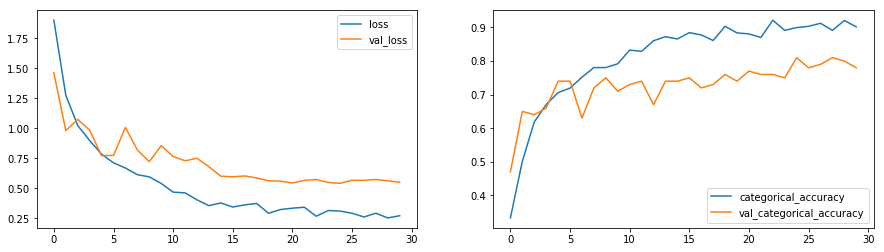

In [11]:
plot(history_model6)


#### For the above low memory foot print model the best validation accuracy of 81%

## Model 7 - reducing the number of parameters

In [12]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_6 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 60, 60, 32)     128       
__________

In [14]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 96s 3s/step - loss: 1.8250 - categorical_accuracy: 0.3230 - val_loss: 1.5888 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2020-09-0815_00_53.670123/model-00001-1.83555-0.32278-1.58882-0.39000.h5
Epoch 2/25
34/34 [==============================] - 88s 3s/step - loss: 1.2733 - categorical_accuracy: 0.5217 - val_loss: 1.1167 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2020-09-0815_00_53.670123/model-00002-1.28366-0.51810-1.11674-0.53000.h5
Epoch 3/25
34/34 [==============================] - 90s 3s/step - loss: 1.0760 - categorical_accuracy: 0.6026 - val_loss: 1.0908 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_2020-09-0815_00_53.670123/model-00003-1.07953-0.60106-1.09084-0.53000.h5
Epoch 4/25
34/34 [==============================] - 89s 3s/step - loss: 0.9507 - categorical_accuracy: 0.6295 - val_loss: 0.9973 - val_categorical_accuracy: 0.5900

Epoch 00004:

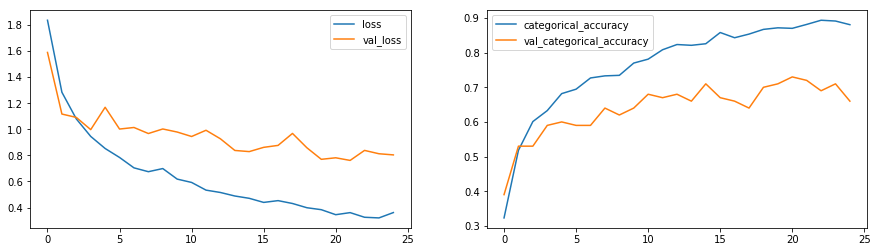

In [15]:
plot(history_model7)


#### For the above low memory foot print model the best validation accuracy of 73%

## Model 8 - reducing the number of parameters

In [16]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_10 (Activation)   (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 60, 60, 16)     64        
__________

In [18]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 230949
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 93s 3s/step - loss: 1.8925 - categorical_accuracy: 0.3208 - val_loss: 1.3177 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-09-0815_38_43.539953/model-00001-1.89053-0.32051-1.31770-0.51000.h5
Epoch 2/30
34/34 [==============================] - 86s 3s/step - loss: 1.4745 - categorical_accuracy: 0.4356 - val_loss: 1.1378 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-09-0815_38_43.539953/model-00002-1.45994-0.44646-1.13784-0.57000.h5
Epoch 3/30
34/34 [==============================] - 88s 3s/step - loss: 1.3070 - categorical_accuracy: 0.4875 - val_loss: 1.0585 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2020-09-0815_38_43.539953/model-00003-1.29230-0.48718-1.05846-0.60000.h5
Epoch 4/30
34/34 [==============================] - 88s 3s/step - loss: 1.2357 - categorical_accuracy: 0.5364 - val_loss: 1.0486 - val_categorical_accuracy: 0.5800

Epoch 00004:


Epoch 00030: saving model to model_init_2020-09-0815_38_43.539953/model-00030-0.43587-0.85596-0.70099-0.74000.h5


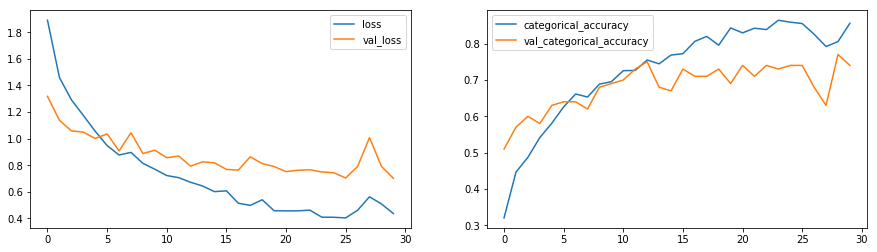

In [19]:
plot(history_model8)


#### For the above low memory foot print model the best validation accuracy of 77%

## Model 9 - CNN- LSTM Model

In [20]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [22]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 161s 5s/step - loss: 1.4567 - categorical_accuracy: 0.3727 - val_loss: 1.5078 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2020-09-0816_22_47.300933/model-00001-1.45514-0.37783-1.50775-0.33000.h5
Epoch 2/20
34/34 [==============================] - 95s 3s/step - loss: 1.1448 - categorical_accuracy: 0.5423 - val_loss: 1.3022 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-09-0816_22_47.300933/model-00002-1.13379-0.54751-1.30219-0.47000.h5
Epoch 3/20
34/34 [==============================] - 97s 3s/step - loss: 0.9092 - categorical_accuracy: 0.6288 - val_loss: 1.0886 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_2020-09-0816_22_47.300933/model-00003-0.90950-0.63198-1.08856-0.55000.h5
Epoch 4/20
34/34 [==============================] - 97s 3s/step - loss: 0.8634 - categorical_accuracy: 0.6567 - val_loss: 0.8294 - val_categorical_accuracy: 0.6500

Epoch 00004

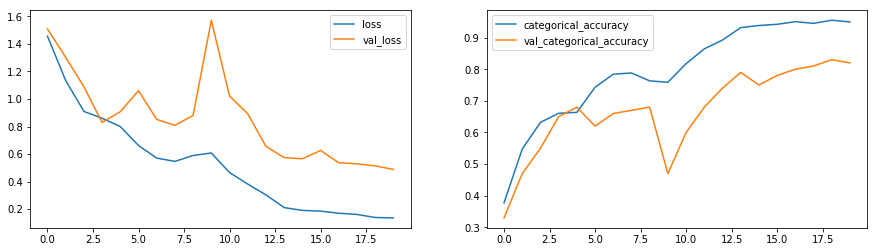

In [23]:
plot(history_model9)


####  For CNN - LSTM model we get a best validation accuracy of 83%. As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

## More Augmentation

In [11]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


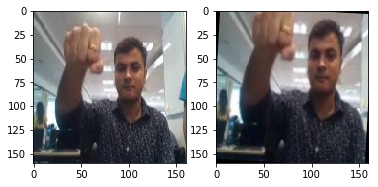

In [12]:
class Test(ModelBuilderMoreAugmentation):
   def define_model(self):
       pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])

## Model 10 - (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [21]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_14 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 80, 80, 32)    128       
__________

In [28]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 3638981
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 164s 5s/step - loss: 1.9710 - categorical_accuracy: 0.3609 - val_loss: 1.4231 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2020-09-0816_56_42.115319/model-00001-1.94062-0.36576-1.42307-0.52000.h5
Epoch 2/30
34/34 [==============================] - 123s 4s/step - loss: 1.5316 - categorical_accuracy: 0.4860 - val_loss: 0.8214 - val_categorical_accuracy: 0.7000

Epoch 00002: saving model to model_init_2020-09-0816_56_42.115319/model-00002-1.49389-0.49397-0.82141-0.70000.h5
Epoch 3/30
34/34 [==============================] - 128s 4s/step - loss: 1.3074 - categorical_accuracy: 0.5467 - val_loss: 0.7971 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2020-09-0816_56_42.115319/model-00003-1.30486-0.55204-0.79713-0.69000.h5
Epoch 4/30
34/34 [==============================] - 129s 4s/step - loss: 1.2246 - categorical_accuracy: 0.5824 - val_loss: 0.9911 - val_categorical_accuracy: 0.6500

Epoch 00

34/34 [==============================] - 128s 4s/step - loss: 0.4462 - categorical_accuracy: 0.8451 - val_loss: 0.5273 - val_categorical_accuracy: 0.8700

Epoch 00030: saving model to model_init_2020-09-0816_56_42.115319/model-00030-0.42261-0.85370-0.52735-0.87000.h5


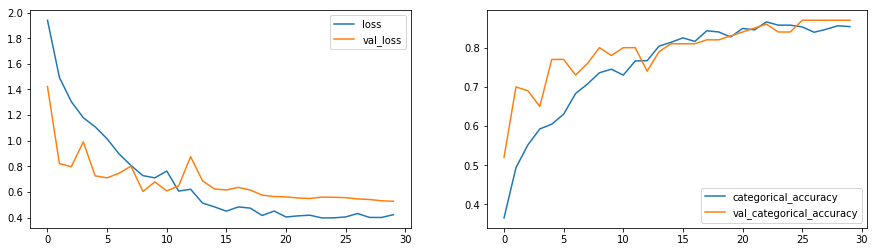

In [29]:
plot(history_model10)


## Model 11 - (2,2,2) Filter & 120x120 Image resolution - similar to Model 3

In [10]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 32)     128       
__________

In [12]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 1762613
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 216s 9s/step - loss: 2.1226 - categorical_accuracy: 0.3447 - val_loss: 1.3656 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2020-09-0914_06_28.205380/model-00001-2.15768-0.33861-1.36559-0.52000.h5
Epoch 2/30
23/23 [==============================] - 90s 4s/step - loss: 1.4535 - categorical_accuracy: 0.5055 - val_loss: 1.0516 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_2020-09-0914_06_28.205380/model-00002-1.48579-0.49925-1.05161-0.58000.h5
Epoch 3/30
23/23 [==============================] - 90s 4s/step - loss: 1.4058 - categorical_accuracy: 0.5165 - val_loss: 0.9300 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-09-0914_06_28.205380/model-00003-1.33953-0.53017-0.93002-0.66000.h5
Epoch 4/30
23/23 [==============================] - 89s 4s/step - loss: 1.1749 - categorical_accuracy: 0.5965 - val_loss: 0.8154 - val_categorical_accuracy: 0.7500

Epoch 00004

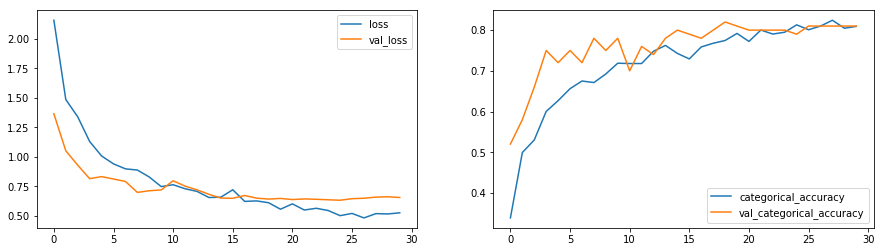

In [13]:
plot(history_model11)


##  Model 12 - Adding more layers - Similar to model 4

In [14]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_6 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [16]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 114s 3s/step - loss: 2.1821 - categorical_accuracy: 0.3267 - val_loss: 2.8157 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2020-09-0914_53_07.193244/model-00001-2.19045-0.32655-2.81574-0.30000.h5
Epoch 2/30
34/34 [==============================] - 93s 3s/step - loss: 1.6413 - categorical_accuracy: 0.4459 - val_loss: 1.2379 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2020-09-0914_53_07.193244/model-00002-1.64064-0.44872-1.23794-0.53000.h5
Epoch 3/30
34/34 [==============================] - 99s 3s/step - loss: 1.4697 - categorical_accuracy: 0.5155 - val_loss: 1.6204 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2020-09-0914_53_07.193244/model-00003-1.45380-0.51584-1.62037-0.49000.h5
Epoch 4/30
34/34 [==============================] - 100s 3s/step - loss: 1.2907 - categorical_accuracy: 0.5291 - val_loss: 1.3532 - val_categorical_accuracy: 0.6200

Epoch 0000

34/34 [==============================] - 96s 3s/step - loss: 0.4010 - categorical_accuracy: 0.8642 - val_loss: 0.6905 - val_categorical_accuracy: 0.7700

Epoch 00030: saving model to model_init_2020-09-0914_53_07.193244/model-00030-0.35758-0.87330-0.69053-0.77000.h5


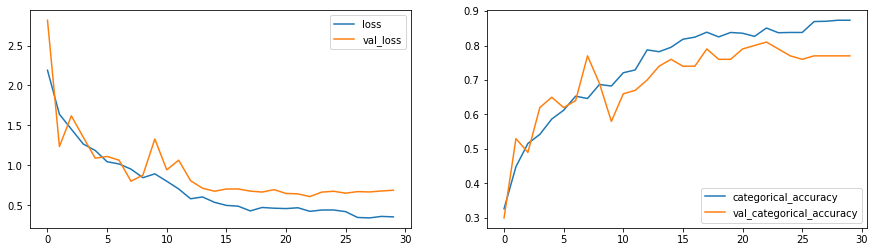

In [17]:
plot(history_model12)

## Model 13 - Adding dropouts - Similar to Model 5

In [18]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_14 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [20]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 2556533
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 103s 3s/step - loss: 1.9860 - categorical_accuracy: 0.3127 - val_loss: 3.1457 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2020-09-0915_42_44.195944/model-00001-1.99823-0.30392-3.14566-0.22000.h5
Epoch 2/25
34/34 [==============================] - 94s 3s/step - loss: 1.6681 - categorical_accuracy: 0.3996 - val_loss: 3.9015 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2020-09-0915_42_44.195944/model-00002-1.64984-0.40121-3.90155-0.23000.h5
Epoch 3/25
34/34 [==============================] - 94s 3s/step - loss: 1.4579 - categorical_accuracy: 0.4551 - val_loss: 2.7607 - val_categorical_accuracy: 0.3100

Epoch 00003: saving model to model_init_2020-09-0915_42_44.195944/model-00003-1.44370-0.46229-2.76068-0.31000.h5
Epoch 4/25
34/34 [==============================] - 93s 3s/step - loss: 1.2453 - categorical_accuracy: 0.5309 - val_loss: 2.6286 - val_categorical_accuracy: 0.3300

Epoch 00004

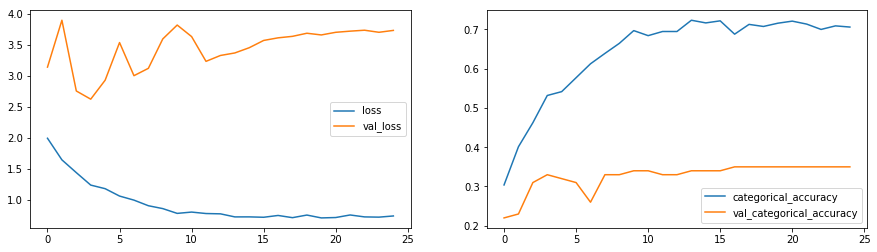

In [21]:
plot(history_model13)


## Model 14 - reducing network parameters - Similar to Model 6


In [22]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=100,image_width=100)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_22 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 8, 50, 50, 32)     128       
__________

In [24]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 696645
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 77s 2s/step - loss: 1.8812 - categorical_accuracy: 0.3315 - val_loss: 1.2440 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2020-09-0916_22_18.142517/model-00001-1.84381-0.33560-1.24398-0.55000.h5
Epoch 2/30
34/34 [==============================] - 69s 2s/step - loss: 1.2813 - categorical_accuracy: 0.5217 - val_loss: 1.0079 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model_init_2020-09-0916_22_18.142517/model-00002-1.27434-0.52640-1.00787-0.62000.h5
Epoch 3/30
34/34 [==============================] - 71s 2s/step - loss: 1.0884 - categorical_accuracy: 0.5868 - val_loss: 1.0635 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2020-09-0916_22_18.142517/model-00003-1.08276-0.58899-1.06348-0.56000.h5
Epoch 4/30
34/34 [==============================] - 71s 2s/step - loss: 0.9185 - categorical_accuracy: 0.6321 - val_loss: 0.9678 - val_categorical_accuracy: 0.6200

Epoch 00004:


Epoch 00029: saving model to model_init_2020-09-0916_22_18.142517/model-00029-0.37520-0.86953-0.76768-0.74000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 3.200000037395512e-07.
Epoch 30/30
34/34 [==============================] - 75s 2s/step - loss: 0.3903 - categorical_accuracy: 0.8602 - val_loss: 0.7661 - val_categorical_accuracy: 0.7400

Epoch 00030: saving model to model_init_2020-09-0916_22_18.142517/model-00030-0.37501-0.86501-0.76613-0.74000.h5


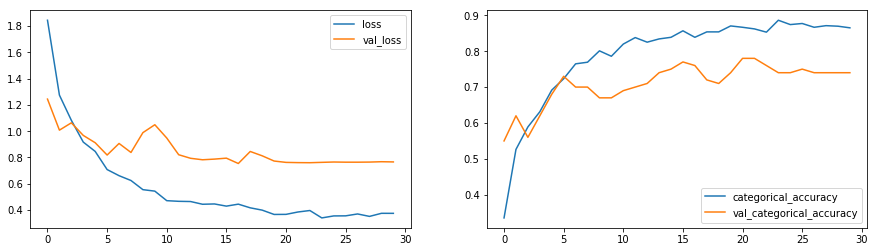

In [25]:
plot(history_model14)


## Model 15 - reducing network parameters - Similar to model 7

In [9]:
class ModelConv3D15(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d15=ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height=120,image_width=120)
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)
conv_3d15_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 32)     128       
__________

In [11]:
print("Total Params:", conv_3d15_model.count_params())
history_model15=conv_3d15.train_model(conv_3d15_model,augment_data=True)

Total Params: 504709
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 211s 6s/step - loss: 1.7841 - categorical_accuracy: 0.3576 - val_loss: 1.5037 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-09-1014_18_09.654347/model-00001-1.79230-0.35822-1.50365-0.53000.h5
Epoch 2/25
34/34 [==============================] - 108s 3s/step - loss: 1.2230 - categorical_accuracy: 0.5419 - val_loss: 1.0648 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-09-1014_18_09.654347/model-00002-1.20670-0.54299-1.06480-0.61000.h5
Epoch 3/25
34/34 [==============================] - 89s 3s/step - loss: 1.0476 - categorical_accuracy: 0.6038 - val_loss: 1.0666 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2020-09-1014_18_09.654347/model-00003-1.02710-0.60633-1.06657-0.65000.h5
Epoch 4/25
34/34 [==============================] - 90s 3s/step - loss: 0.9567 - categorical_accuracy: 0.6255 - val_loss: 0.9663 - val_categorical_accuracy: 0.6300

Epoch 0000

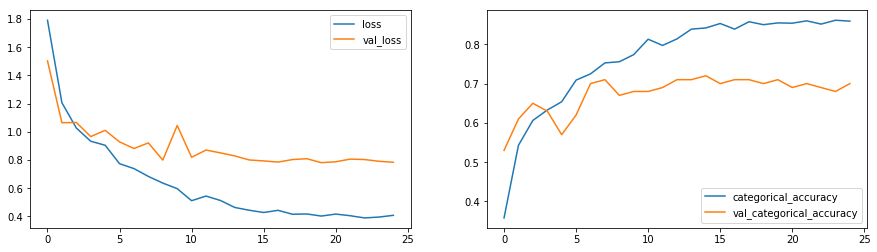

In [12]:
plot(history_model15)


## Model 16 - reducing network parameters - Similar to Model 8

In [13]:
class ModelConv3D16(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d16=ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height=120,image_width=120)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)
conv_3d16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 60, 60, 16)     64        
__________

In [15]:
print("Total Params:", conv_3d16_model.count_params())
history_model16=conv_3d16.train_model(conv_3d16_model,augment_data=True)

Total Params: 230949
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 93s 3s/step - loss: 2.0654 - categorical_accuracy: 0.2605 - val_loss: 1.4483 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-09-1014_57_46.052471/model-00001-2.07679-0.25867-1.44831-0.47000.h5
Epoch 2/30
34/34 [==============================] - 86s 3s/step - loss: 1.6319 - categorical_accuracy: 0.3650 - val_loss: 1.2399 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-09-1014_57_46.052471/model-00002-1.61808-0.37406-1.23993-0.57000.h5
Epoch 3/30
34/34 [==============================] - 88s 3s/step - loss: 1.4555 - categorical_accuracy: 0.4352 - val_loss: 1.1952 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-09-1014_57_46.052471/model-00003-1.44668-0.44193-1.19518-0.64000.h5
Epoch 4/30
34/34 [==============================] - 87s 3s/step - loss: 1.3732 - categorical_accuracy: 0.4753 - val_loss: 0.9970 - val_categorical_accuracy: 0.5700

Epoch 00004:


Epoch 00029: saving model to model_init_2020-09-1014_57_46.052471/model-00029-0.60721-0.77602-0.79381-0.72000.h5
Epoch 30/30
34/34 [==============================] - 91s 3s/step - loss: 0.6415 - categorical_accuracy: 0.7656 - val_loss: 0.7938 - val_categorical_accuracy: 0.7200

Epoch 00030: saving model to model_init_2020-09-1014_57_46.052471/model-00030-0.60284-0.78054-0.79384-0.72000.h5


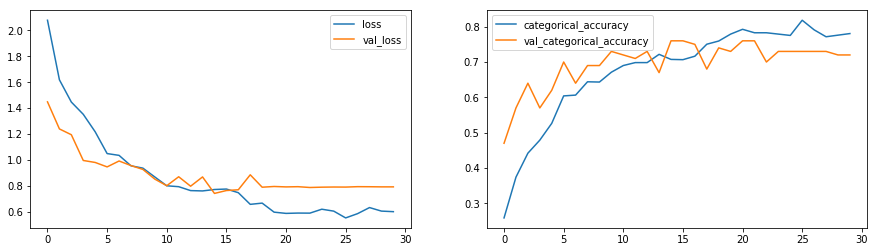

In [16]:
plot(history_model16)


## Model 17 - CNN LSTM with GRU - Similar to Model 9

In [9]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [11]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573541
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 219s 6s/step - loss: 1.4931 - categorical_accuracy: 0.3473 - val_loss: 1.1172 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2020-09-1114_08_08.871027/model-00001-1.49931-0.33937-1.11722-0.55000.h5
Epoch 2/20
34/34 [==============================] - 121s 4s/step - loss: 1.0323 - categorical_accuracy: 0.5721 - val_loss: 1.0619 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-09-1114_08_08.871027/model-00002-1.02696-0.58220-1.06195-0.55000.h5
Epoch 3/20
34/34 [==============================] - 101s 3s/step - loss: 0.8963 - categorical_accuracy: 0.6670 - val_loss: 0.9433 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2020-09-1114_08_08.871027/model-00003-0.89414-0.66290-0.94328-0.65000.h5
Epoch 4/20
34/34 [==============================] - 100s 3s/step - loss: 0.7541 - categorical_accuracy: 0.7222 - val_loss: 0.9039 - val_categorical_accuracy: 0.5900

Epoch 00

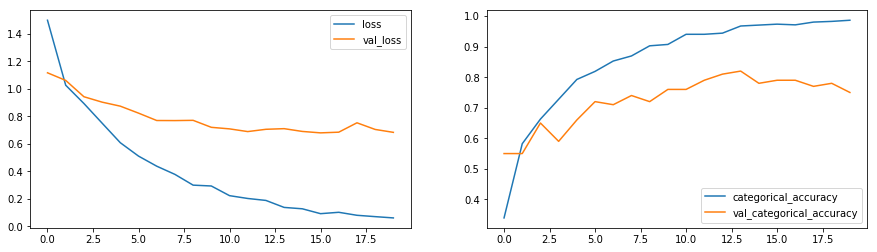

In [12]:
plot(history_model17)


#### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

## Model 18 - Transfer Learning

In [13]:
from keras.applications import mobilenet


In [14]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 2s 0us/step


In [15]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
__________

In [16]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 141s 1s/step - loss: 1.4680 - categorical_accuracy: 0.3449 - val_loss: 1.2652 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-09-1114_44_09.133657/model-00001-1.46930-0.34389-1.26521-0.51000.h5
Epoch 2/20
133/133 [==============================] - 81s 613ms/step - loss: 1.1759 - categorical_accuracy: 0.5281 - val_loss: 1.2403 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2020-09-1114_44_09.133657/model-00002-1.17716-0.52715-1.24028-0.44000.h5
Epoch 3/20
133/133 [==============================] - 84s 635ms/step - loss: 1.0542 - categorical_accuracy: 0.5940 - val_loss: 1.1028 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-09-1114_44_09.133657/model-00003-1.04997-0.59578-1.10280-0.50000.h5
Epoch 4/20
133/133 [==============================] - 82s 618ms/step - loss: 1.0001 - categorical_accuracy: 0.6165 - val_loss: 1.1456 - val_categorical_accuracy: 0.

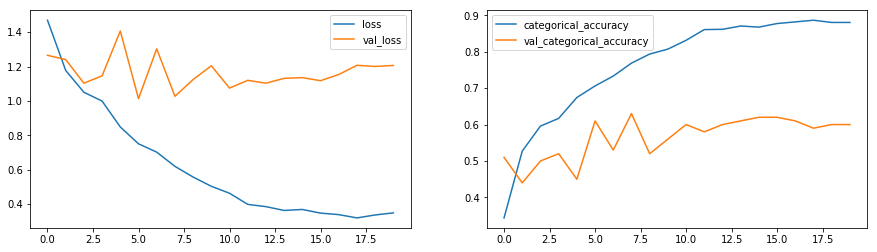

In [17]:
plot(history_model18)


#### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

## Model 19 - Transfer Learning with GRU and training all weights

In [14]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 2s 0us/step


In [19]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
__________

In [20]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3692869
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 99s 747ms/step - loss: 1.2757 - categorical_accuracy: 0.4805 - val_loss: 1.2269 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model_init_2020-09-1115_14_58.575332/model-00001-1.27734-0.48039-1.22693-0.41000.h5
Epoch 2/20
133/133 [==============================] - 90s 678ms/step - loss: 0.7851 - categorical_accuracy: 0.7025 - val_loss: 0.6878 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to model_init_2020-09-1115_14_58.575332/model-00002-0.78566-0.70211-0.68776-0.64000.h5
Epoch 3/20
133/133 [==============================] - 91s 685ms/step - loss: 0.5495 - categorical_accuracy: 0.8050 - val_loss: 0.3990 - val_categorical_accuracy: 0.8400

Epoch 00003: saving model to model_init_2020-09-1115_14_58.575332/model-00003-0.54926-0.80543-0.39896-0.84000.h5
Epoch 4/20
133/133 [==============================] - 88s 665ms/step - loss: 0.5304 - categorical_accuracy: 0.8020 - val_loss: 0.6439 - val_categorical_accuracy: 

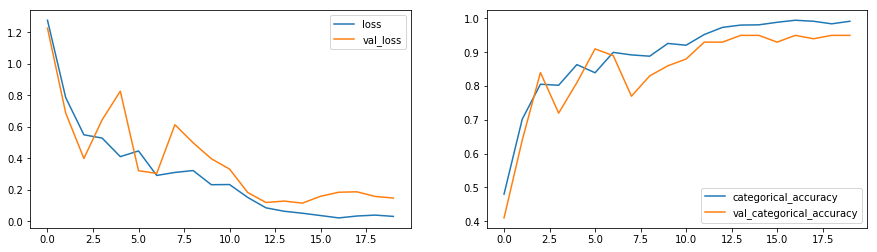

In [21]:
plot(history_model19)


## Loading model and Testing

In [10]:
import time
from keras.models import load_model
model = load_model('model-00020-0-Copy1.03061-0.99170-0.14723-0.95000.h5')

In [40]:
test_generator=ModelConv3D10()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

# rnn_cnn_tl2=RNNCNN_TL2()
# rnn_cnn_tl2.initialize_path(project_folder)
# rnn_cnn_tl2.initialize_image_properties(image_height=160,image_width=160)
# rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=20,batch_size=5,num_epochs=1)

# g=test_generator.generator(rnn_cnn_tl2.val_path,rnn_cnn_tl2.val_doc,augment=True)
# batch_data, batch_labels=next(g)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


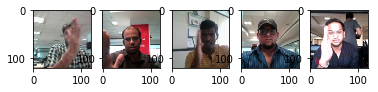

In [43]:
# batch_labels
fig, axes = plt.subplots(nrows=1, ncols=5)
# axes[0].imshow(batch_data[25,25,25,25,25])   
# axes[1].imshow(batch_data[15,15,15,15,15])
axes[0].imshow(batch_data[0,6,:,:,:])   
axes[1].imshow(batch_data[1,6,:,:,:])
axes[2].imshow(batch_data[2,6,:,:,:])   
axes[3].imshow(batch_data[3,6,:,:,:])
axes[4].imshow(batch_data[4,6,:,:,:])
# batch_data.shape

In [44]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))


[0 1 0 1 1]
